In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../")

,f0,f1,f2,f3,f4,f5,f6,choice
count,5.000000e+05,500000.000000,500000.000000,5.000000e+05,5.000000e+05,500000.000000,500000.000000,500000.000000
mean,5.000345e-01,0.499119,0.499807,4.997701e-01,5.004074e-01,0.500340,0.500170,0.872046
std,2.885085e-01,0.288588,0.288812,2.887852e-01,2.886899e-01,0.288587,0.288518,0.840806
min,2.067514e-07,0.000001,0.000003,6.036102e-07,3.675153e-07,0.000001,0.000004,0.000000
25%,2.495431e-01,0.249102,0.249847,2.497404e-01,2.503285e-01,0.250324,0.250375,0.000000
50%,5.004717e-01,0.498962,0.499696,4.997621e-01,5.006968e-01,0.500867,0.500369,1.000000
75%,7.502534e-01,0.748964,0.749937,7.498617e-01,7.502342e-01,0.750317,0.750107,2.000000
max,9.999945e-01,0.999999,0.999994,9.999985e-01,9.999960e-01,0.999999,1.000000,2.000000


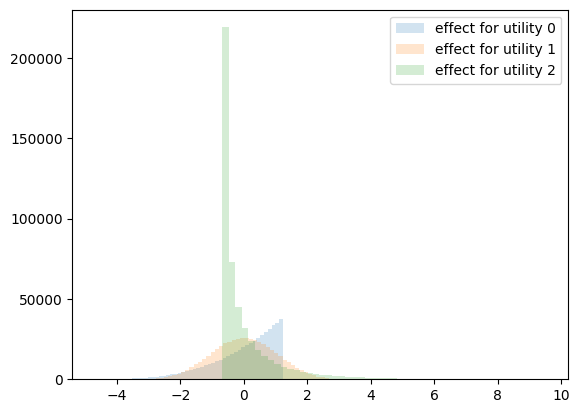

In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax
from rumboost.metrics import mse, cross_entropy
np.random.seed(0)

def compute_levels(sp, betas):
    levels = np.zeros(len(sp))
    for i in range(len(sp) - 1):
        levels[i + 1] = levels[i] + (sp[i + 1] - sp[i]) * betas[i]
    return levels


def create_pw_linear_feature(x, sp, betas, intercept):
    indices = np.searchsorted(sp, x) - 1
    levels = compute_levels(sp, betas) + intercept
    f_x = levels[indices] + betas[indices] * (x - sp[indices])

    return f_x


def apply_linear_feature(x_arr, sp, betas, feature_names, intercept):
    data = pd.DataFrame(
        {
            feature_names[i]: np.array(
                create_pw_linear_feature(x, sp[i], betas[i], intercept[i])
            )
            for i, x in enumerate(x_arr.T)
        }
    )
    return data


def create_pw_constant_feature(x, sp, betas, intercept):
    indices = np.searchsorted(sp, x) - 1
    f_x = betas[indices] + intercept

    return f_x

def apply_constant_feature(x_arr, sp, betas, feature_names, intercept):
    data = pd.DataFrame(
        {
            feature_names[i]: np.array(
                create_pw_constant_feature(x, sp[i], betas[i], intercept[i])
            )
            for i, x in enumerate(x_arr.T)
        }
    )
    return data

def create_sinusoidal_feature(x, sp, betas, intercept):
    indices = np.searchsorted(sp, x) - 1
    f_x = np.sin(betas[indices] * x) + intercept
    return f_x

def apply_sinusoidal_feature(x_arr, sp, betas, feature_names, intercept):
    data = pd.DataFrame(
        {
            feature_names[i]: np.array(
                create_sinusoidal_feature(x, sp[i], betas[i], intercept[i])
            )
            for i, x in enumerate(x_arr.T)
        }
    )
    return data


def create_dataset(x_arr: np.ndarray, feature_names: list) -> pd.DataFrame:
    return pd.DataFrame({feature_names[i]: x_arr[:, i] for i in range(x_arr.shape[1])})


def generate_x(n, k, props_low=0.5, cut=0.5, deterministic=False, gaussian=False, semi_random=False):
    n_low = int(props_low * n)
    n_high = n - n_low
    if deterministic:
        x_low = np.linspace([0]*n_utility, [cut]*n_utility, n_low)
        x_high = np.linspace([cut]*n_utility, [1]*n_utility, n_high)
    elif gaussian:
        x_low = np.random.normal(loc=0, scale=cut, size=(n_low, k))
        x_high = np.random.normal(loc=cut, scale=1-cut, size=(n_high, k))
        x_low = np.clip(x_low, 0, cut)
        x_high = np.clip(x_high, cut, 1)
    elif semi_random:
        x_low = np.random.choice(np.linspace(0, cut-1, cut), (n_low, k))
        x_high = np.random.choice(np.linspace(cut-1, cut, cut), (n_high, k))
    else:
        x_low = np.random.uniform(0, cut, (n_low, k))
        x_high = np.random.uniform(cut, 1, (n_high, k))

    return np.concatenate([x_low, x_high], axis=0)

def nullify_features(x_arr: np.ndarray, feature_indices: list) -> np.ndarray:
    """
    Nullify the features in the dataset by setting them to zero.
    """
    x_arr[:, feature_indices] = np.zeros((x_arr.shape[0], len(feature_indices)))
    return x_arr

def create_functional_effects(x: np.ndarray, n_utility: int, n_socio_dem: int) -> np.ndarray:
    """
    Create functional effects for a given number of utilities and features per utility.
    """
    effects = np.zeros((x.shape[0], n_utility))
    for i in range(n_utility):
        if i == 0:
            effects[:, i] = np.max(x[:, :n_socio_dem], axis=1) 
        elif i == 1:
            effects[:, i] = np.sum(x[:, :n_socio_dem], axis=1)
        elif i == 2:
            effects[:, i] = np.prod(x[:, :n_socio_dem], axis=1) 
        else:
            effects[:, i] = np.median(x[:, :n_socio_dem], axis=1)

        effects[:, i] = effects[:,i] / effects[:, i].max()
        effects[:, i] = ((effects[:, i] - effects[:, i].mean())/effects[:, i].std())

        # effects[:, i] += np.random.normal(loc=0, scale=0.1, size=effects[:, i].shape)

    # effects = effects - effects[:, -1].reshape(-1, 1)
            
    return effects

def create_dumb_functional_effects(x: np.ndarray, n_utility: int, n_socio_dem: int) -> np.ndarray:
    """
    Create functional effects for a given number of utilities and features per utility.
    """
    effects = np.zeros((x.shape[0], n_utility))
    for i in range(n_utility):
        if i == 0:
            effects[:, i] = np.where(x[:, :n_socio_dem].sum(axis=1) < 2, 1, 0)
        elif i == 1:
            effects[:, i] = np.where(x[:, :n_socio_dem].sum(axis=1) < 2, 1, -1)
        elif i == 2:
            effects[:, i] = np.where(x[:, :n_socio_dem].sum(axis=1) < 2, 0.5, -0.5)
        else:
            effects[:, i] = np.where(x[:, :n_socio_dem].sum(axis=1) < 2, 2, 1)

        # effects[:, i] /= effects[:, i].max()

        # effects[:, i] += np.random.normal(loc=0, scale=0.1, size=effects[:, i].shape)

            
    return effects

def apply_functional_effects(x: np.ndarray, n_utility: int, n_socio_dem: int) -> pd.DataFrame:
    """
    Apply functional effects to the input data and return a DataFrame.
    """
    effects = create_functional_effects(x, n_utility, n_socio_dem)
    # effects = create_dumb_functional_effects(x, n_utility, n_socio_dem)
    feature_names = [f"f{i}" for i in range(n_utility)]
    
    return pd.DataFrame(effects, columns=feature_names)

def add_alt_spec_features(dataset_transformed: pd.DataFrame, x_alt: np.ndarray, n_utility: int, coeff: list, n_socio_dem: int) -> pd.DataFrame:
    """
    Add alternative specific features to the transformed dataset.
    """
    
    for i in range(n_utility):
        dataset_transformed.iloc[:, i] += coeff[i] * x_alt[:, i + n_socio_dem]
        # dataset_transformed.iloc[:, i] += coeff[i] * x_alt[:, n_socio_dem]
        # dataset_transformed.iloc[:, i] += np.sum(coeff * x_alt[:, n_socio_dem:], axis=1)

    
    return dataset_transformed

def add_choice(row, u_idx, regression=False):
    u = np.array([np.sum(row[u_idx[i][0] : u_idx[i][1]]) for i in range(len(u_idx))])
    # p = u-u.min()
    # p = p/(p.sum())
    p = softmax(u)
    if regression:
        return u[0]
    else:
        # return np.random.choice(u.shape[0], size=1, p=p)[0]
        return np.argmax(u) 

n_utility = 3
regression = n_utility == 1
f_per_utility = 5
n_alt_spec = 1
n_socio_dem = 4
tot_features = n_socio_dem + n_utility * n_alt_spec
x_arr = generate_x(500000, tot_features, 1, 1, gaussian=False, semi_random=False)
x_arr_test = generate_x(100000, tot_features, 1, 1, gaussian=False, semi_random=False)
# x_arr = nullify_features(x_arr, [i + n_socio_dem for i in range(n_utility)])
# x_arr_test = nullify_features(x_arr_test, [i + n_socio_dem for i in range(n_utility)])

# coeff = [-1, -1, -1, -1]
coeff = [0, 0, 0, 0]

feature_names = [f"f{i}" for i in range(tot_features)]

u_idx = [(i, (i+1)) for i in range(n_utility)]

y_plot = apply_functional_effects(x_arr, n_utility, n_socio_dem)
for i in range(n_utility):
    plt.hist(y_plot.iloc[:, i], label = f"effect for utility {i}", alpha = 0.2, bins=50)
    plt.legend()

dataset = create_dataset(x_arr, feature_names)
dataset_transf = apply_functional_effects(x_arr, n_utility, n_socio_dem)
dataset_transf = add_alt_spec_features(dataset_transf, x_arr, n_utility, coeff, n_socio_dem)
dataset["choice"] = dataset_transf.apply(add_choice, axis=1, u_idx=u_idx, regression=regression)
dataset_test = create_dataset(x_arr_test, feature_names)
dataset_test_transf = apply_functional_effects(x_arr_test, n_utility, n_socio_dem)
dataset_test_transf = add_alt_spec_features(dataset_test_transf, x_arr_test, n_utility, coeff, n_socio_dem)
dataset_test["choice"] = dataset_test_transf.apply(add_choice, axis=1, u_idx=u_idx, regression=regression)

dataset.describe()

In [106]:
dataset_transf

,f0,f1,f2
0,-0.518025,0.715971,0.727970
1,1.003275,1.789191,2.168935
2,0.200954,-1.712648,-0.678429
3,-0.003916,0.278661,-0.307835
4,-0.156521,-0.040628,-0.195627
...,...,...,...
499995,0.177849,-0.340238,-0.373386
499996,-1.125528,-0.934428,-0.555340
499997,0.381162,1.144913,0.510933
499998,-0.174805,-0.474559,-0.610845


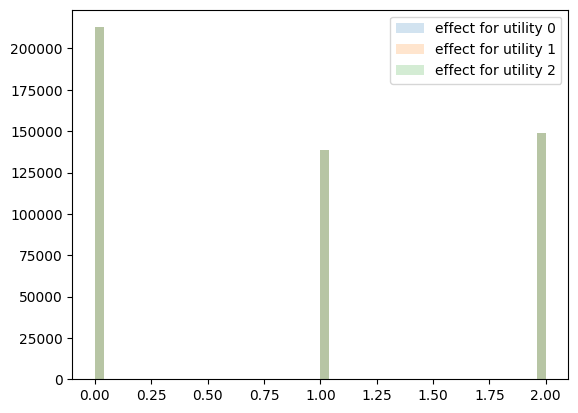

In [108]:
for i in range(n_utility):
    plt.hist(np.argmax(dataset_transf, axis=1), label = f"effect for utility {i}", alpha = 0.2, bins=50)
    # plt.hist((dataset_transf.values[:, i]), label = f"effect for utility {i}", alpha = 0.2, bins=50)
    plt.legend()

In [109]:
from models_wrapper import RUMBoost, TasteNet
from parser import parse_cmdline_args
from synthetic_experiment import gather_functional_intercepts, l1_distance

alt_spec_features = {i: [f"f{i+n_socio_dem}"] for i in range(n_utility)}
# alt_spec_features = {i: [f"f{n_socio_dem}"] for i in range(n_utility)}
# alt_spec_features = {i: [f"f4", "f5", "f6", "f7"] for i in range(n_utility)}
# alt_spec_features = {0: []}
socio_demo_chars = [f"f{i}" for i in range(n_socio_dem)]
X_train = dataset.drop(columns=["choice"])
X_val = dataset_test.drop(columns=["choice"])
y_train = dataset["choice"]
y_val = dataset_test["choice"]

In [110]:
import torch
import gc

gc.collect()
torch.cuda.empty_cache()

In [115]:
model = "RUMBoost"
args = parse_cmdline_args()
args.functional_intercept = True
args.functional_params = False
args.feature_fraction = 1.0
args.save_model = True
args.model = model
args.dataset = "synthetic"
args.learning_rate = 1
args.device = "cuda"
args.num_iterations = 1000
args.early_stopping_rounds = None 
args.num_leaves = 15

model = RUMBoost(
    alt_spec_features=alt_spec_features,
    socio_demo_chars=socio_demo_chars,
    num_classes=n_utility,
    args=args,
    )

# build dataloader
model.build_dataloader(X_train, y_train, X_val, y_val)

# fit model
best_train_loss, best_val_loss = model.fit()


# predict on the test set
preds, _, _ = model.predict(X_val)
if regression:
    loss_test = mse(preds, y_val)
else:
    loss_test = cross_entropy(preds, y_val)



c:\Users\ucesnjs\OneDrive - University College London\Documents\PhD - UCL\panel-data\src\rumboost\rumboost.py:2680: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Using torch tensors on cuda
[LightGBM] [Warning] Unknown parameter: max_booster_to_update
[LightGBM] [Warning] Unknown parameter: verbose_interval
[LightGBM] [Warning] Unknown parameter: max_booster_to_update
[LightGBM] [Warning] Unknown parameter: verbose_interval
[1]------NCE value on train set : 1.0035
---------NCE value on test set 1: 1.0034
[11]-----NCE value on train set : 0.5776
---------NCE value on test set 1: 0.5782
[21]-----NCE value on train set : 0.4276
---------NCE value on test set 1: 0.4286
[31]-----NCE value on train set : 0.3478
---------NCE value on test set 1: 0.3492
[41]-----NCE value on train set : 0.2981
---------NCE value on test set 1: 0.3000
[51]-----NCE value on train set : 0.2686
---------NCE value on test set 1: 0.2709
[61]-----NCE value on train set : 0.2446
---------NCE value on test set 1: 0.2471
[71]-----NCE value on train set : 0.2246
---------NCE value on test set 1: 0.2272
[81]-----NCE value on train set : 0.2099
---------NCE value on test set 1: 0.2

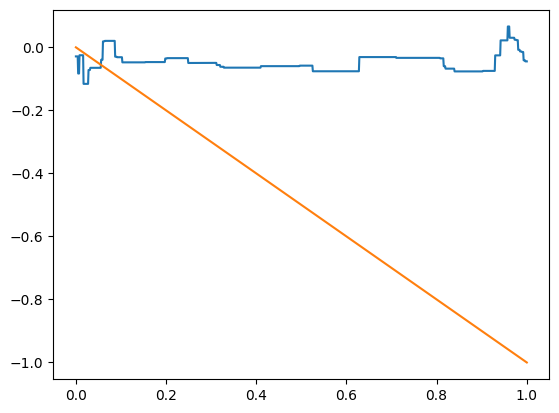

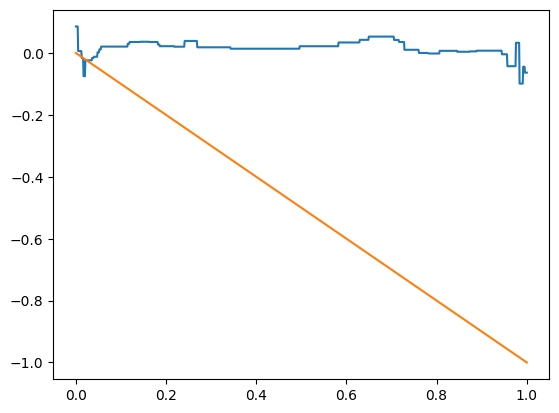

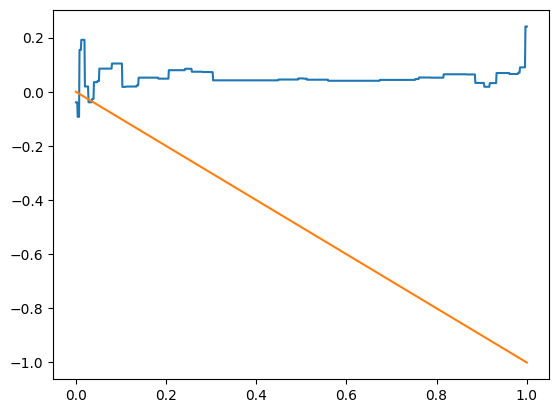

In [116]:
x_plot = np.linspace(0, 1, 1000).reshape(-1, 1)
y_alt = []
for booster in model.model.boosters[:-n_utility]:
    plt.figure()
    y_plot = booster.predict(x_plot)
    y_a = booster.predict(dataset.iloc[:, i+n_socio_dem].values.reshape(-1,1))
    plt.plot(x_plot, y_plot, label="predicted utility")
    plt.plot(x_plot, -x_plot, label="true utility")
    y_alt.append(y_a)

In [117]:
# get learnt functional intercepts
learnt_fct_intercepts = gather_functional_intercepts(
    dataset, model, socio_demo_chars, n_utility
)
learnt_fct_intercepts_test = gather_functional_intercepts(
    dataset_test, model, socio_demo_chars, n_utility
)

# compute L1 distance between true and learnt functional intercepts
l1_distance_train = l1_distance(
    dataset_transf,
    learnt_fct_intercepts,
)
l1_distance_test = l1_distance(
    dataset_test_transf,
    learnt_fct_intercepts_test,
)

print(f"Best Train Loss: {best_train_loss}, Best Val Loss: {best_val_loss}")
print(f"Test Loss: {loss_test}")

Best Train Loss: 0.048110827803611755, Best Val Loss: 0.056896090507507324
Test Loss: 0.05689608935113697


c:\Users\ucesnjs\anaconda32\envs\old_rumboost\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


In [122]:
learnt_fct_intercepts.shape

(500000, 3)

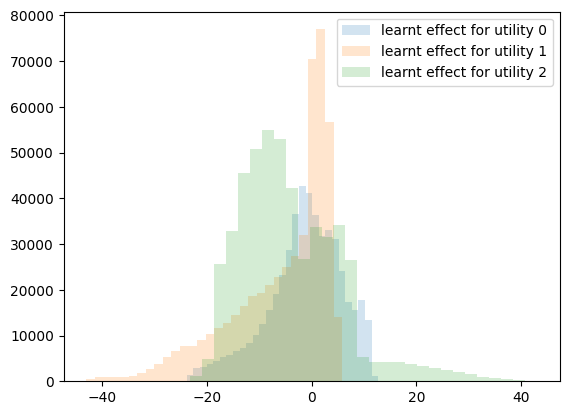

In [121]:
for i in range(n_utility):
    plt.hist(learnt_fct_intercepts[:,i], label = f"learnt effect for utility {i}", alpha = 0.2, bins=30)
    plt.legend()
    # plt.hist(softmax(learnt_fct_intercepts_test,axis=1)[:,i], label = f"learnt effect for utility {i}", alpha = 0.2, bins=50)

In [58]:
X_train

,f0,f1,f2,f3,f4,f5,f6,f7
0,0.274407,0.357595,0.301382,0.272442,0.211827,0.322947,0.218794,0.445887
1,0.481831,0.191721,0.395863,0.264447,0.284022,0.462798,0.035518,0.043565
2,0.010109,0.416310,0.389078,0.435006,0.489309,0.399579,0.230740,0.390265
3,0.059137,0.319961,0.071677,0.472334,0.260924,0.207331,0.132278,0.387117
4,0.228075,0.284217,0.009395,0.308818,0.306048,0.308467,0.471874,0.340910
...,...,...,...,...,...,...,...,...
49995,0.971324,0.578283,0.897749,0.602421,0.923117,0.551295,0.912668,0.530713
49996,0.695958,0.795138,0.631632,0.735137,0.888064,0.601362,0.773209,0.857661
49997,0.805179,0.560490,0.912764,0.635194,0.649465,0.987844,0.564101,0.967400
49998,0.868632,0.962352,0.921625,0.848464,0.888963,0.683833,0.905745,0.766267


In [129]:
import lightgbm as lgb

train_set = lgb.Dataset(X_train[["f0", "f1", "f2", "f3"]], label=y_train)
val_set = lgb.Dataset(X_val[["f0", "f1", "f2", "f3"]], label=y_val)

params = {
          "objective": "multiclass" if not regression else "regression",
          "num_class": n_utility,
          "verbosity": 1,
          "num_leaves": 15,
          "learning_rate": 0.1,
          "metric": "multi_logloss" if not regression else "mse",
          "boosting_type": "gbdt",
          "lambda_l1": 0.1,
          "lambda_l2": 0.1,}
model = lgb.train(params, train_set, num_boost_round=100)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001194 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 500000, number of used features: 4
[LightGBM] [Info] Start training from score -0.854161
[LightGBM] [Info] Start training from score -1.284915
[LightGBM] [Info] Start training from score -1.211716


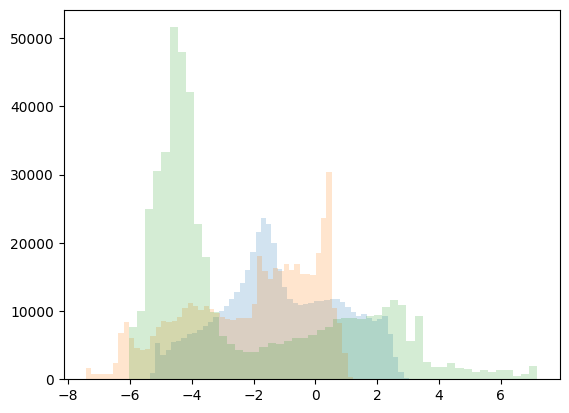

In [130]:
x_plot = dataset[["f0", "f1", "f2", "f3"]].copy()
preds = model.predict(x_plot, raw_score=True)

for i, p in enumerate(preds.T):
    plt.hist(p, bins=50, alpha=0.2, label=f"predicted effects for utility {i}")
    # plt.hist(softmax(preds, axis=1)[:,i], bins=50, alpha=0.2, label=f"predicted effects for utility {i}")

In [20]:
model = "TasteNet"
args = parse_cmdline_args()
args.functional_intercept = True
args.functional_params = False
args.feature_fraction = 1.0
args.save_model = True
args.model = model
args.dataset = "synthetic"


model = TasteNet(
    alt_spec_features=alt_spec_features,
    socio_demo_chars=socio_demo_chars,
    num_classes=n_utility,
    num_latent_vals=None,
    args=args,
)

# build dataloader
model.build_dataloader(X_train, y_train, X_val, y_val)

# fit model
best_train_loss, best_val_loss = model.fit()


# predict on the test set
preds, _, _ = model.predict(X_val)
loss_test = mse(preds, y_val)



/home/nicolas-salvade/miniforge3/envs/share/lib/python3.13/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/home/nicolas-salvade/miniforge3/envs/share/lib/python3.13/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 0])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (0) must match the size of tensor b (256) at non-singleton dimension 1